In [3]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from operator import eq
import pandas as pd
#import pandas_ta as ta
import matplotlib
import matplotlib.pyplot as plt
import yfinance as yf

import datetime
from pathlib import Path

## IMPORT SKLEARN
from sklearn import tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV

from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz, DMatrix

import numpy as np
plt.style.use('seaborn')
from pprint import pprint

In [5]:
# IMPORT TENSORFLOW AND KERAS
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

df = pd.DataFrame()

In [6]:


def set_seeds(seed=2022): 
    random.seed(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)



In [7]:
equityData = data = yf.download('BTC-USD', start="2017-08-01",end="2022-10-02")
equityData.dropna(inplace=True)
equityData.drop(index=equityData.index[0], axis=0, inplace=True)
equityData.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-01,2871.300049,2921.350098,2685.610107,2718.260010,2718.260010,1324669952
2017-08-02,2727.129883,2762.530029,2668.590088,2710.669922,2710.669922,1094950016
2017-08-03,2709.560059,2813.310059,2685.139893,2804.729980,2804.729980,804796992
2017-08-04,2806.929932,2899.330078,2743.719971,2895.889893,2895.889893,1002120000
2017-08-05,2897.629883,3290.010010,2874.830078,3252.909912,3252.909912,1945699968


In [8]:
### Path to store results

results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [9]:
data = equityData['Adj Close']

data = data.to_numpy()
data = np.reshape(data, (-1, 1))
data.shape

(1888, 1)

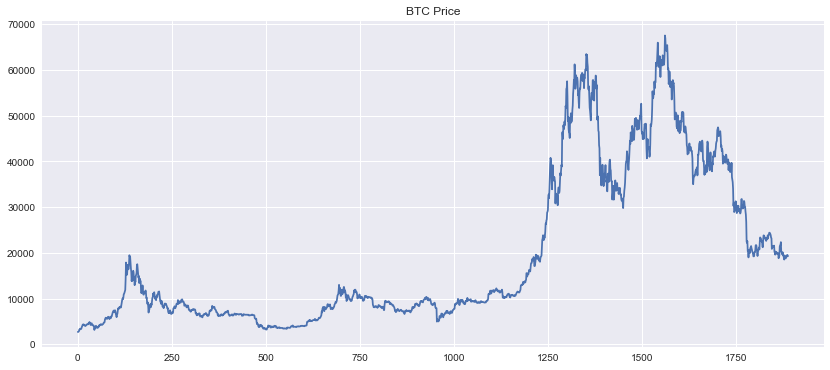

In [10]:
# Visualization 
plt.figure(figsize=(14,6))
plt.title('BTC Price')
plt.plot(data);

In [11]:
#### TRAIN - TEST SPLIT
# Splitting the datasets into training and testing data.
train_data, test_data = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(train_data)}, {len(test_data)}")

Train and Test Size 1510, 378


In [12]:
#### PREPROCESSING
# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [13]:
#### GENERATE SEQUENCE

def generate_sequence(data, sequence_length=60):
    
    # create X & y data array
    X = []
    y = []

    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i, 0])
        y.append(data[i, 0])
    
    # Converting x_train and y_train to Numpy arrays
    return np.array(X), np.array(y)

In [14]:
# sequence length
lookback = 60

In [15]:
X_train, y_train = generate_sequence(data=scaled_train_data, sequence_length=lookback)
print(f'X_train: {X_train.shape}, y_train {y_train.shape}')

X_train: (1450, 60), y_train (1450,)


In [16]:
X_test, y_test = generate_sequence(data=scaled_test_data, sequence_length=lookback)
print(f'X_test: {X_test.shape}, y_test {y_test.shape}')

X_test: (318, 60), y_test (318,)


In [17]:
#### RESHAPE

# reshaping array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train[:, np.newaxis] 

# check the array size
print(f'X_train Shape: {X_train.shape}, y_train {y_train.shape}')

X_train Shape: (1450, 60, 1), y_train (1450, 1)


In [18]:
# reshaping test array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = y_test[:, np.newaxis] 

# check the test array size
print(f'X_test Shape: {X_test.shape}, y_test {y_test.shape}')

X_test Shape: (318, 60, 1), y_test (318, 1)


In [19]:
#### CREATE THE MODEL
def create_model(hu=256, lookback=60):

    tensorflow.keras.backend.clear_session()   
    
    # instantiate the model
    model = Sequential()
    model.add(LSTM(units=hu, input_shape=(lookback, 1), activation = 'relu', return_sequences=False, name='LSTM'))
    model.add(Dense(units=1, name='Output'))              # can also specify linear activation function 
    
    # specify optimizer separately (preferred method))
#     opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)       # adam optimizer seems to perform better for a single lstm
    
    # model compilation
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    
    return model

In [20]:
# lstm network
model = create_model(hu=10, lookback=lookback)

In [21]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [22]:
#### TRAIN THE MODEL
# Specify callback functions
model_path = (results_path / 'model.h5').as_posix()
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

my_callbacks = [
    EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

In [23]:
# Model fitting
lstm_training = model.fit(X_train, 
                          y_train, 
                          batch_size=64, 
                          epochs=500, 
                          verbose=1, 
                          callbacks=my_callbacks, 
                          shuffle=False)

Epoch 1/500
22/23 [===========================>..] - ETA: 0s - loss: 0.1037 - mae: 0.2002
Epoch 1: loss improved from inf to 0.11920, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 3s 28ms/step - loss: 0.1192 - mae: 0.2175
Epoch 2/500
22/23 [===========================>..] - ETA: 0s - loss: 0.0844 - mae: 0.1548
Epoch 2: loss improved from 0.11920 to 0.09794, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 1s 24ms/step - loss: 0.0979 - mae: 0.1718
Epoch 3/500
22/23 [===========================>..] - ETA: 0s - loss: 0.0687 - mae: 0.1356
Epoch 3: loss improved from 0.09794 to 0.07970, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 1s 24ms/step - loss: 0.0797 - mae: 0.1511
Epoch 4/500
22/23 [===========================>..] - ETA: 0s - loss: 0.0585 - mae: 0.1435
Epoch 4: loss improved from 0.07970 to 0.06749, saving model to results/lstm_time_series\model.h5
23/

20/23 [=========================>....] - ETA: 0s - loss: 5.8087e-04 - mae: 0.0147
Epoch 31: loss improved from 0.00099 to 0.00096, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 17ms/step - loss: 9.6115e-04 - mae: 0.0189
Epoch 32/500
21/23 [==========================>...] - ETA: 0s - loss: 8.2238e-04 - mae: 0.0162
Epoch 32: loss improved from 0.00096 to 0.00094, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 17ms/step - loss: 9.3861e-04 - mae: 0.0182
Epoch 33/500
20/23 [=========================>....] - ETA: 0s - loss: 5.3420e-04 - mae: 0.0133
Epoch 33: loss improved from 0.00094 to 0.00092, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 9.2412e-04 - mae: 0.0177
Epoch 34/500
20/23 [=========================>....] - ETA: 0s - loss: 5.2467e-04 - mae: 0.0130
Epoch 34: loss improved from 0.00092 to 0.00092, saving model to results/ls

20/23 [=========================>....] - ETA: 0s - loss: 4.7724e-04 - mae: 0.0122
Epoch 60: loss improved from 0.00085 to 0.00085, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 8.4719e-04 - mae: 0.0165
Epoch 61/500
23/23 [==============================] - ETA: 0s - loss: 8.4459e-04 - mae: 0.0165
Epoch 61: loss improved from 0.00085 to 0.00084, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 20ms/step - loss: 8.4459e-04 - mae: 0.0165
Epoch 62/500
20/23 [=========================>....] - ETA: 0s - loss: 4.7425e-04 - mae: 0.0121
Epoch 62: loss improved from 0.00084 to 0.00084, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 8.4196e-04 - mae: 0.0165
Epoch 63/500
20/23 [=========================>....] - ETA: 0s - loss: 4.7269e-04 - mae: 0.0121
Epoch 63: loss improved from 0.00084 to 0.00084, saving model to results/ls

22/23 [===========================>..] - ETA: 0s - loss: 7.3020e-04 - mae: 0.0157
Epoch 89: loss improved from 0.00076 to 0.00075, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 19ms/step - loss: 7.4823e-04 - mae: 0.0161
Epoch 90/500
23/23 [==============================] - ETA: 0s - loss: 7.3058e-04 - mae: 0.0164
Epoch 90: loss improved from 0.00075 to 0.00073, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 19ms/step - loss: 7.3058e-04 - mae: 0.0164
Epoch 91/500
21/23 [==========================>...] - ETA: 0s - loss: 6.6007e-04 - mae: 0.0157
Epoch 91: loss improved from 0.00073 to 0.00071, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 20ms/step - loss: 7.1428e-04 - mae: 0.0169
Epoch 92/500
23/23 [==============================] - ETA: 0s - loss: 7.3074e-04 - mae: 0.0180
Epoch 92: loss did not improve from 0.00071
23/23 [========================

23/23 [==============================] - 0s 18ms/step - loss: 4.8706e-04 - mae: 0.0127
Epoch 119/500
21/23 [==========================>...] - ETA: 0s - loss: 4.3658e-04 - mae: 0.0115
Epoch 119: loss improved from 0.00049 to 0.00048, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 4.8428e-04 - mae: 0.0126
Epoch 120/500
20/23 [=========================>....] - ETA: 0s - loss: 3.1994e-04 - mae: 0.0099
Epoch 120: loss improved from 0.00048 to 0.00048, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 19ms/step - loss: 4.8187e-04 - mae: 0.0126
Epoch 121/500
20/23 [=========================>....] - ETA: 0s - loss: 3.1817e-04 - mae: 0.0099
Epoch 121: loss improved from 0.00048 to 0.00048, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 4.7893e-04 - mae: 0.0125
Epoch 122/500
20/23 [=========================>....] - ETA: 0s -

23/23 [==============================] - 0s 20ms/step - loss: 4.1449e-04 - mae: 0.0119
Epoch 148/500
22/23 [===========================>..] - ETA: 0s - loss: 3.9844e-04 - mae: 0.0115
Epoch 148: loss improved from 0.00041 to 0.00041, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 20ms/step - loss: 4.1280e-04 - mae: 0.0119
Epoch 149/500
23/23 [==============================] - ETA: 0s - loss: 4.0945e-04 - mae: 0.0118
Epoch 149: loss improved from 0.00041 to 0.00041, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 19ms/step - loss: 4.0945e-04 - mae: 0.0118
Epoch 150/500
21/23 [==========================>...] - ETA: 0s - loss: 3.6088e-04 - mae: 0.0107
Epoch 150: loss improved from 0.00041 to 0.00041, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 4.0759e-04 - mae: 0.0118
Epoch 151/500
23/23 [==============================] - ETA: 0s -

23/23 [==============================] - 0s 18ms/step - loss: 3.6366e-04 - mae: 0.0111
Epoch 178/500
20/23 [=========================>....] - ETA: 0s - loss: 2.4598e-04 - mae: 0.0093
Epoch 178: loss did not improve from 0.00036
23/23 [==============================] - 0s 18ms/step - loss: 3.7089e-04 - mae: 0.0116
Epoch 179/500
21/23 [==========================>...] - ETA: 0s - loss: 3.1829e-04 - mae: 0.0099
Epoch 179: loss improved from 0.00036 to 0.00036, saving model to results/lstm_time_series\model.h5
23/23 [==============================] - 0s 18ms/step - loss: 3.6298e-04 - mae: 0.0111
Epoch 180/500
20/23 [=========================>....] - ETA: 0s - loss: 2.4837e-04 - mae: 0.0095
Epoch 180: loss did not improve from 0.00036
23/23 [==============================] - 0s 19ms/step - loss: 3.7388e-04 - mae: 0.0117
Epoch 181/500
20/23 [=========================>....] - ETA: 0s - loss: 2.4392e-04 - mae: 0.0087
Epoch 181: loss did not improve from 0.00036
23/23 [==========================

In [ ]:
%tensorboard --logdir logs

In [24]:
#### ERROR CALC


# calculate rmse of loss function
train_rmse_scaled = np.sqrt(model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled[0]:.4f} | Test RMSE: {test_rmse_scaled[0]:.4f}')

Train RMSE: 0.0200 | Test RMSE: 0.0288


In [25]:
# predictions
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 6ms/step


In [26]:
df = pd.DataFrame({
    'actual': scaler.inverse_transform(y_test).flatten(),
    'prediction': scaler.inverse_transform(y_pred).flatten()})

df['spread'] = df['prediction'] - df['actual']
df

,actual,prediction,spread
0,56942.136719,60372.339844,3430.203125
1,58119.578125,58122.921875,3.343750
2,59697.195312,57011.179688,-2686.015625
3,58730.476562,57152.347656,-1578.128906
4,56289.289062,57100.289062,811.000000
...,...,...,...
313,19110.546875,19756.013672,645.466797
314,19426.720703,19763.400391,336.679688
315,19573.050781,19861.888672,288.837891
316,19431.789062,19986.988281,555.199219


In [27]:
print(f'R-square: {r2_score(df.actual, df.prediction):0.4}')

R-square: 0.9763


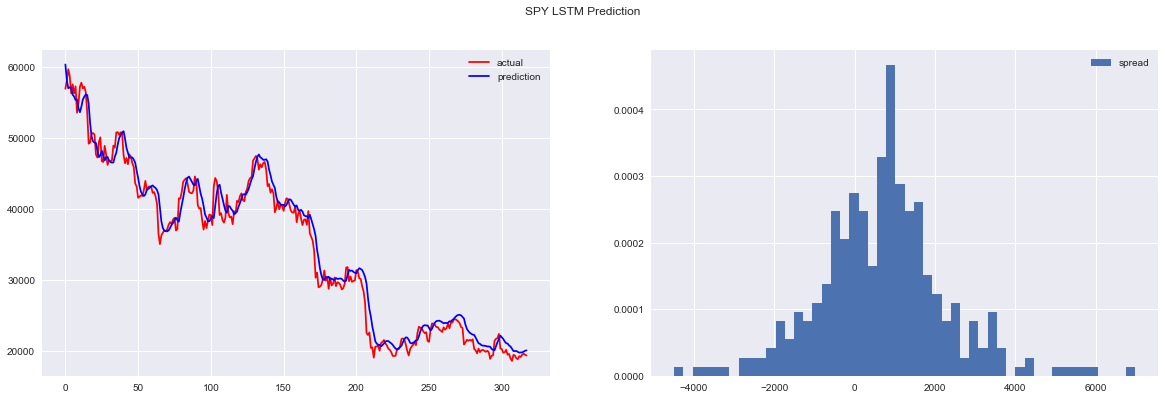

In [28]:
#### PLOT RESULTS
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax[0].plot(df.actual, color='red', label='actual')
ax[0].plot(df.prediction, color='blue', label='prediction')
ax[1].hist(df.spread, bins=50, density=True, label='spread')

ax[0].legend()
ax[1].legend()

plt.suptitle('SPY LSTM Prediction');

In [ ]:
X_test.shape

In [29]:
std = np.copy(scaled_test_data)
std.shape

(378, 1)

In [30]:
pr = []
pr = np.array(pr)


In [31]:
for i in range (0,5):
    m=[]
    m.append(std[318+i:378+i, 0])
    m1 = np.array(m)
    m2 = np.reshape(m1, (m1.shape[0], m1.shape[1], 1))
    p = model.predict(m2)
    std = np.append(std, p)
    std = np.reshape(std, (-1, 1))
    pr = np.append(pr, scaler.inverse_transform(p).flatten())

1/1 [==============================] - 0s 44ms/step


In [32]:
pr

array([20046.0234375 , 20260.68554688, 20498.49023438, 20746.171875  ,
       21002.94726562])